In [1]:
#逻辑，用routes的航线中的机场代码，匹配机场airports.dat中的数据- 这个数据中第五列是IATA代码，第三列是城市的名称，可以相对应，然后建立有向网络
#后期如果不需要可以换成无向网络，然后边就是航线，边的属性就是（航空公司，起点和重点的IATA代码，距离，中转次数）
#另外需要各个城市的地理坐标（后续用来绘制航线图）
#然后合并边，看看是不是属于一个城市的，（比如我知道的有的城市有2个机场，例如上海），这种情况下合并为一个节点，但是边不合并，各自连接到新的节点上
#至于如何区分，可以通过边的属性区分

In [2]:
# #wiki百科爬机场数据代码（到时候直接变成markdown代码的形式）
# import requests
# from bs4 import BeautifulSoup
# import pandas as pd

# # 目标URL
# url = "https://en.wikipedia.org/wiki/List_of_international_airports_by_country"

# # 请求网页内容
# response = requests.get(url)
# soup = BeautifulSoup(response.content, "html.parser")

# # 初始化列表用于存储数据
# data = {
#     "Country": [],
#     "Airport": [],
#     "IATA Code": []
# }

# # 遍历每个国家的机场信息表格
# for table in soup.find_all("table", {"class": "wikitable"}):
#     country = None  # 初始化国家名
#     for row in table.find_all("tr")[1:]:  # 跳过表头行
#         cells = row.find_all("td")
        
#         # 判断是否为国家行（通常包含 3 列）
#         if len(cells) == 3:
#             country = cells[0].text.strip()
#             airport = cells[1].text.strip()
#             iata_code = cells[2].text.strip()
#         elif len(cells) == 2:  # 如果只有两列，使用前面的国家名
#             airport = cells[0].text.strip()
#             iata_code = cells[1].text.strip()
        
#         # 添加数据到列表
#         if country and airport and iata_code:
#             data["Country"].append(country)
#             data["Airport"].append(airport)
#             data["IATA Code"].append(iata_code)

# # 转换为DataFrame
# df = pd.DataFrame(data)

# # 显示或保存数据
# print(df)
# # df.to_csv("international_airports.csv", index=False) # 保存为CSV文件

In [3]:
# #得到航线代码的文件的代码，同理markdown代码的形式
# import requests

# # URL of the routes.dat file
# url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

# # 目标文件路径
# file_path = "airports.dat"

# try:
#     # 发送GET请求
#     response = requests.get(url)
#     response.raise_for_status()  # 检查请求是否成功

#     # 将内容写入文件
#     with open(file_path, "wb") as file:
#         file.write(response.content)
#     print(f"文件已成功下载并保存为 {file_path}")

# except requests.exceptions.RequestException as e:
#     print(f"下载文件时出错: {e}")

In [4]:
#第一步，处理数据，用IATA链接城市，新城新的完整的文件

In [5]:
import pandas as pd

In [6]:
# 读取 airports.dat 文件
airports_df = pd.read_csv("airports.dat", header=None, encoding="utf-8", names=[
    "ID", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude",
    "Altitude", "Timezone", "DST", "TzDatabase", "Type", "Source"
])

In [7]:
# 读取 routes.dat 文件
routes_df = pd.read_csv("routes.dat", header=None, encoding="utf-8", names=[
    "Airline", "AirlineID", "SourceIATA", "SourceAirportID", "DestinationIATA",
    "DestinationAirportID", "Codeshare", "Stops", "Equipment"
])

In [8]:
# 创建 IATA 到城市名称的映射
iata_to_city = dict(zip(airports_df["IATA"], airports_df["City"]))

# 添加起点城市列
routes_df["SourceCity"] = routes_df["SourceIATA"].map(iata_to_city)

# 添加终点城市列
routes_df["DestinationCity"] = routes_df["DestinationIATA"].map(iata_to_city)

# 保存到新的 CSV 文件
routes_df.to_csv("routes_with_cities.csv", index=False, encoding="utf-8")

print("routes_with_cities.csv completed")

routes_with_cities.csv completed


In [9]:
#更新城市经纬度坐标在这个routes_with_cities.csv文件中

In [10]:
iata_to_coords = dict(zip(airports_df["IATA"], zip(airports_df["Latitude"], airports_df["Longitude"])))

In [11]:
routes_df["SourceLatitude"] = routes_df["SourceIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[0])
routes_df["SourceLongitude"] = routes_df["SourceIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[1])


In [12]:
routes_df["DestinationLatitude"] = routes_df["DestinationIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[0])
routes_df["DestinationLongitude"] = routes_df["DestinationIATA"].map(lambda x: iata_to_coords.get(x, (None, None))[1])


In [13]:
# 保存到新的 CSV 文件
routes_df.to_csv("routes_with_cities_and_coords.csv", index=False, encoding="utf-8")

print("routes_with_cities_and_coords.csv completed")


routes_with_cities_and_coords.csv completed


In [14]:
#下面的代码是开始构建网络了

In [15]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import networkx as nx
from geopy.distance import geodesic

In [17]:
routes_df = pd.read_csv("routes_with_cities_and_coords.csv", encoding="utf-8")

In [18]:
G = nx.MultiDiGraph()#允许两点之间存在多条边，因为边的属性不一样

In [19]:
missing_city_count = 0  # 缺失城市行数
missing_coords_count = 0  # 缺失坐标行数
total_rows = len(routes_df)  # 总航线行数

In [20]:
# 遍历数据集，逐行添加边
for _, row in routes_df.iterrows():
    source_city = row["SourceCity"]
    destination_city = row["DestinationCity"]

    # 跳过无效的行（缺少城市）
    if pd.isna(source_city) or pd.isna(destination_city):
        missing_city_count += 1
        continue

    # 边的属性（用 None 替代缺失值）
    airline = row.get("Airline", None)
    source_iata = row.get("SourceIATA", None)
    destination_iata = row.get("DestinationIATA", None)
    stops = row.get("Stops", None)
    equipment = row.get("Equipment", None)

    # 计算距离（处理缺失经纬度的情况）
    try:
        source_coords = (row["SourceLatitude"], row["SourceLongitude"])
        destination_coords = (row["DestinationLatitude"], row["DestinationLongitude"])
        distance = geodesic(source_coords, destination_coords).kilometers
    except (ValueError, TypeError):
        distance = None

    # 添加边到图中，每行数据对应一条边
    G.add_edge(
        source_city,
        destination_city,
        key=(airline, source_iata, destination_iata),  # 唯一标识符
        airline=airline,
        source_iata=source_iata,
        destination_iata=destination_iata,
        distance=distance,
        stops=stops,
        equipment=equipment
    )


In [21]:
# 打印过滤统计信息（中文）
print(f"total airline: {total_rows}")
print(f"missing cities rows: {missing_city_count}")
print(f"missing coords rows: {missing_coords_count}")

# 打印网络的基本信息（中文）
print(f"nodes: {G.number_of_nodes()}")
print(f"edges: {G.number_of_edges()}")


total airline: 67663
missing cities rows: 733
missing coords rows: 0
nodes: 3135
edges: 66930


In [22]:
#below 是 degree distribution分析

nodes: 3135
edges: 66930
average in-degree: 21.35
average out-degree: 21.35
max in-degree: 1224
max out-degree: 1232


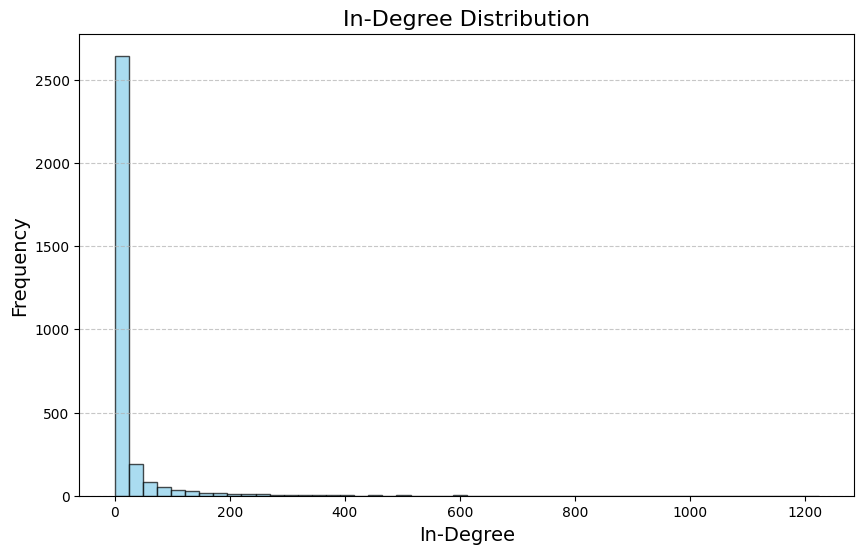

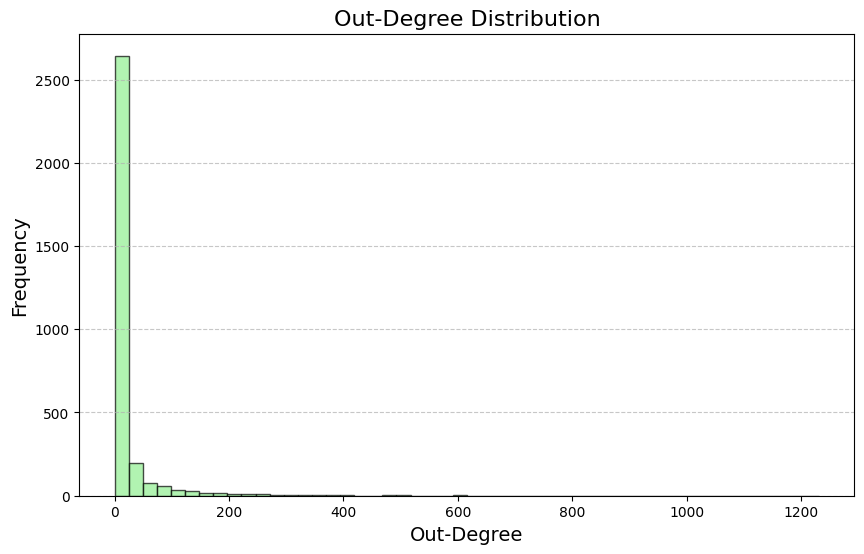

In [23]:
import matplotlib.pyplot as plt

# 计算入度和出度
in_degrees = [deg for _, deg in G.in_degree()]  # 节点的入度列表
out_degrees = [deg for _, deg in G.out_degree()]  # 节点的出度列表

# 打印关键统计信息
print(f"nodes: {G.number_of_nodes()}")  # 网络中的节点数量
print(f"edges: {G.number_of_edges()}")  # 网络中的边数量
print(f"average in-degree: {sum(in_degrees) / len(in_degrees):.2f}")  # 平均入度
print(f"average out-degree: {sum(out_degrees) / len(out_degrees):.2f}")  # 平均出度
print(f"max in-degree: {max(in_degrees)}")  # 最大入度
print(f"max out-degree: {max(out_degrees)}")  # 最大出度

# 绘制入度分布图
plt.figure(figsize=(10, 6))
plt.hist(in_degrees, bins=50, color="skyblue", edgecolor="black", alpha=0.7)  # 入度分布
plt.title("In-Degree Distribution", fontsize=16)  # 标题
plt.xlabel("In-Degree", fontsize=14)  # x轴标签
plt.ylabel("Frequency", fontsize=14)  # y轴标签
plt.grid(axis="y", linestyle="--", alpha=0.7)  # 网格线
plt.show()

# 绘制出度分布图
plt.figure(figsize=(10, 6))
plt.hist(out_degrees, bins=50, color="lightgreen", edgecolor="black", alpha=0.7)  # 出度分布
plt.title("Out-Degree Distribution", fontsize=16)  # 标题
plt.xlabel("Out-Degree", fontsize=14)  # x轴标签
plt.ylabel("Frequency", fontsize=14)  # y轴标签
plt.grid(axis="y", linestyle="--", alpha=0.7)  # 网格线
plt.show()
